Imports and directory required

In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm
import pandas as pd

# Root path where original ShanghaiTech dataset lives
DATA_ROOT = r"C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\data\ShanghaiTech"

# Output directory inside your project where preprocessed files will be saved
OUT_DIR = r"C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\outputs"   

# Desired size for training (width, height)
TARGET_SIZE = (512, 512)   # <-- change if you want different input size

# JPEG compression quality (0-100)
JPEG_QUALITY = 85

# Gaussian sigma for density map (in pixels on the TARGET_SIZE grid)
DENSITY_SIGMA = 4

# Whether to overwrite existing preprocessed files
OVERWRITE = False
# ------------------------------------------------------------

# make paths absolute and create outdir
DATA_ROOT = Path(DATA_ROOT)
OUT_DIR = Path(OUT_DIR)
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT:", DATA_ROOT)
print("OUT_DIR:", OUT_DIR)
print("TARGET_SIZE (W,H):", TARGET_SIZE)

DATA_ROOT: C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\data\ShanghaiTech
OUT_DIR: C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\outputs
TARGET_SIZE (W,H): (512, 512)


Helper functions (do not edit unless you know what you change)

In [3]:

def load_gt_points(mat_path):
    """Load GT points from ShanghaiTech .mat file structure.
       Returns Nx2 numpy array with columns [x, y] (floats).
    """
    d = loadmat(str(mat_path))
    pts = d['image_info'][0][0][0][0][0]
    pts = pts.astype(np.float32)
    return pts

def preprocess_image_cv2(img_bgr, target_size=(512,512), compress_quality=85):
    """Resize (cv2), convert BGR->RGB and compress using JPEG quality.
       Returns image in RGB with float32 range [0,1].
    """
    target_w, target_h = target_size
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (target_w, target_h), interpolation=cv2.INTER_AREA)

    # compress to JPEG and read back (to simulate on-disk saving artifacts if desired)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), compress_quality]
    success, enc = cv2.imencode('.jpg', cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR), encode_param)
    if success:
        img_resized = cv2.imdecode(enc, cv2.IMREAD_COLOR)
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    img_out = img_resized.astype(np.float32) / 255.0
    return img_out  # shape (H, W, 3), float32

def scale_points(points, orig_shape, target_size):
    """Scale [x,y] points from orig_shape (H_orig, W_orig) to target_size (W_target,H_target)."""
    H_orig, W_orig = orig_shape[:2]
    W_t, H_t = target_size
    pts = points.astype(np.float32).copy()
    pts[:,0] = pts[:,0] * (W_t / W_orig)
    pts[:,1] = pts[:,1] * (H_t / H_orig)
    return pts

def generate_density_map(H, W, points_scaled, sigma=4):
    """Generate density map of shape (H, W). After gaussian smoothing,
       rescale the density so sum == number of points (integral equals count).
    """
    density = np.zeros((H, W), dtype=np.float32)
    for p in points_scaled:
        x = int(round(p[0]))
        y = int(round(p[1]))
        if x < 0 or x >= W or y < 0 or y >= H:
            continue
        density[y, x] += 1.0
    density = gaussian_filter(density, sigma=sigma, mode='constant')
    s = density.sum()
    if s > 0:
        density = density * (len(points_scaled) / s)
    return density


In [4]:
# process a single dataset split (helper)
def process_split(part_name, split_name, data_root, out_root,
                  target_size=(512,512), jpeg_quality=85, sigma=4, overwrite=False):
    """
    part_name: "part_A" or "part_B"
    split_name: "train_data" or "test_data"
    data_root: Path to dataset root
    out_root: Path to output base
    """
    images_dir = data_root / part_name / split_name / "images"
    gt_dir = data_root / part_name / split_name / "ground-truth"

    # where processed files will go:
    out_images_dir = out_root / part_name / split_name / "images"
    out_density_dir = out_root / part_name / split_name / "density"
    out_images_dir.mkdir(parents=True, exist_ok=True)
    out_density_dir.mkdir(parents=True, exist_ok=True)

    manifest = []

    img_files = sorted([f for f in images_dir.iterdir() if f.suffix.lower() in ('.jpg', '.png', '.jpeg')])
    if len(img_files) == 0:
        print(f"Warning: no images found in {images_dir}")
        return manifest

    for img_path in tqdm(img_files, desc=f"{part_name}/{split_name}"):
        base_name = img_path.stem   # e.g. 'IMG_1'
        mat_name = f"GT_{base_name}.mat"
        mat_path = gt_dir / mat_name
        if not mat_path.exists():
            # skip if ground truth missing
            print(f"Missing GT for {img_path.name} -> {mat_name} (skipping)")
            continue

        # output filenames
        out_img_file = out_images_dir / (base_name + ".jpg")
        out_den_file = out_density_dir / (base_name + ".npy")

        if out_img_file.exists() and out_den_file.exists() and not overwrite:
            # collect metadata quickly
            density = np.load(out_den_file)
            manifest.append({
                "part": part_name, "split": split_name, "img_name": base_name,
                "img_path": str(out_img_file), "density_path": str(out_den_file),
                "gt_count": float(density.sum())
            })
            continue

        # read and preprocess
        img_bgr = cv2.imread(str(img_path))
        if img_bgr is None:
            print(f"Failed reading image {img_path} (skipping).")
            continue

        orig_h, orig_w = img_bgr.shape[:2]
        points = load_gt_points(mat_path)
        img_proc = preprocess_image_cv2(img_bgr, target_size=target_size, compress_quality=jpeg_quality)
        points_scaled = scale_points(points, (orig_h, orig_w), target_size)

        # generate density map on target grid (H,W)
        W_t, H_t = target_size
        density = generate_density_map(H_t, W_t, points_scaled, sigma=sigma)

        # save processed image (RGB float [0,1]) as JPEG on disk (0-255)
        img_to_save = (np.clip(img_proc,0,1)*255).astype(np.uint8)[:, :, ::-1]  # back to BGR for cv2
        cv2.imwrite(str(out_img_file), img_to_save, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality])

        # save density map as .npy (float32)
        np.save(str(out_den_file), density.astype(np.float32))

        manifest.append({
            "part": part_name, "split": split_name, "img_name": base_name,
            "img_path": str(out_img_file), "density_path": str(out_den_file),
            "gt_count": float(density.sum())
        })

    return manifest


In [5]:
# Running preprocessing for Part_A and Part_B (this may take time)
all_manifest = []

# Part A train
m1 = process_split("part_A", "train_data", DATA_ROOT, OUT_DIR,
                   target_size=TARGET_SIZE, jpeg_quality=JPEG_QUALITY, sigma=DENSITY_SIGMA, overwrite=OVERWRITE)
all_manifest.extend(m1)

# Part A test (if exists)
m2 = process_split("part_A", "test_data", DATA_ROOT, OUT_DIR,
                   target_size=TARGET_SIZE, jpeg_quality=JPEG_QUALITY, sigma=DENSITY_SIGMA, overwrite=OVERWRITE)
all_manifest.extend(m2)

# Part B train
m3 = process_split("part_B", "train_data", DATA_ROOT, OUT_DIR,
                   target_size=TARGET_SIZE, jpeg_quality=JPEG_QUALITY, sigma=DENSITY_SIGMA, overwrite=OVERWRITE)
all_manifest.extend(m3)

# Part B test
m4 = process_split("part_B", "test_data", DATA_ROOT, OUT_DIR,
                   target_size=TARGET_SIZE, jpeg_quality=JPEG_QUALITY, sigma=DENSITY_SIGMA, overwrite=OVERWRITE)
all_manifest.extend(m4)

# Save manifest CSV
manifest_df = pd.DataFrame(all_manifest)
manifest_csv = OUT_DIR / "preprocess_manifest.csv"
manifest_df.to_csv(manifest_csv, index=False)
print("Saved manifest to:", manifest_csv)


part_A/train_data:   0%|          | 0/300 [00:00<?, ?it/s]

part_A/test_data:   0%|          | 0/182 [00:00<?, ?it/s]

part_B/train_data:   0%|          | 0/400 [00:00<?, ?it/s]

part_B/test_data:   0%|          | 0/316 [00:00<?, ?it/s]

Saved manifest to: C:\Users\ACEPC\Desktop\DeepVision Crowd Monitoring\outputs\preprocess_manifest.csv


{'part': 'part_B', 'split': 'test_data', 'img_name': 'IMG_178', 'img_path': 'C:\\Users\\ACEPC\\Desktop\\DeepVision Crowd Monitoring\\outputs\\part_B\\test_data\\images\\IMG_178.jpg', 'density_path': 'C:\\Users\\ACEPC\\Desktop\\DeepVision Crowd Monitoring\\outputs\\part_B\\test_data\\density\\IMG_178.npy', 'gt_count': 40.9999885559082}


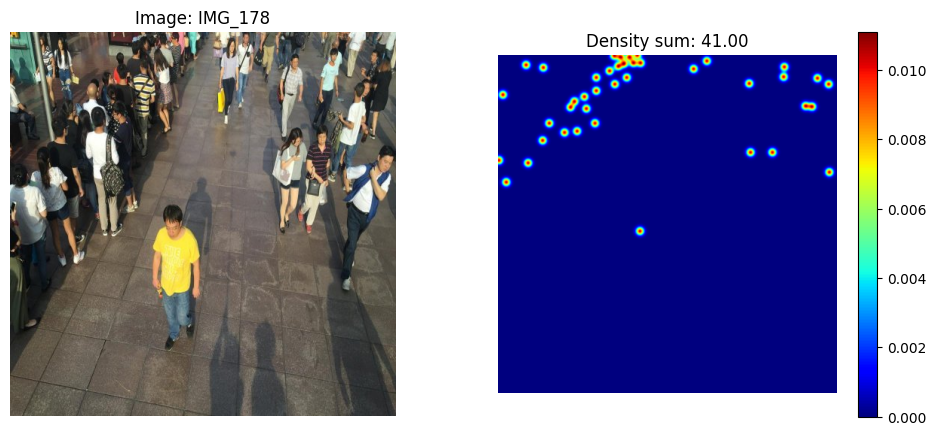

In [7]:
#  quick verification: show a random sample
import random
if len(manifest_df) > 0:
    sample = manifest_df.sample(1).iloc[0]
    img_p = sample['img_path']
    den_p = sample['density_path']
    print(sample.to_dict())

    img = cv2.imread(img_p)  # BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    den = np.load(den_p)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Image: {sample['img_name']}")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(den, cmap='jet')
    plt.title(f"Density sum: {den.sum():.2f}")
    plt.colorbar()
    plt.axis('off')
    plt.show()
else:
    print("No preprocessed files found in manifest.")
